**import**

In [1]:
# Import Moudles and Packages
import gc
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import time
import random

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["axes.grid"]=False

# Import pytorch modules
import torch
import torch.nn as nn
from torch.utils import data as D

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler
from madgrad import MADGRAD

import natsort

import gc
import torch

from mpl_toolkits.axes_grid1 import ImageGrid
from torchsummary import summary
gc.collect()
torch.cuda.empty_cache()

device = 'cuda:1' if torch.cuda.is_available() else 'cpu'

print("__Import modules and packages__\n")
print("| Pytorch version: {}".format(torch.__version__))
print("| GPU: {}".format(torch.cuda.is_available()))
print("| Device : ",device)
print("| Device name: ", torch.cuda.get_device_name(0))
print("| Device count: ", torch.cuda.device_count())

__Import modules and packages__

| Pytorch version: 1.10.0+cu102
| GPU: True
| Device :  cuda:1
| Device name:  Tesla T4
| Device count:  4


**model**

In [2]:
from src.models import resnet, xception
model = xception.XceptionNet(num_classes=54)
model.eval()
model = model.to(device)


In [3]:
import src.dataset.kface_dataset as K
import src.dataset.kface_transform_A as A

**dataset**

In [4]:
import src.config as C
k_dataset_train = K.kfacedataset(
    type="train",
    transform=A.get_augmentation(data_type="train")
    )

k_dataset_valid = K.kfacedataset(
    type="valid",
    transform=A.get_augmentation(data_type="valid")
    )

**dataloader**

In [5]:
train_dataset, _ = D.random_split(k_dataset_train, [4320, 1080])
_, valid_dataset = D.random_split(k_dataset_valid, [4320, 1080])

BATCH_SIZE = 64

train_loader = D.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
valid_loader = D.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=4)

print(f'{len(train_dataset)} images for training')
print(f'{len(valid_dataset)} images for validating')

4320 images for training
1080 images for validating


In [6]:
# import pandas as pd
# import cv2
# data_path = "/data/komedi/dataset/540x1L_kface_nocropped/540_27pt_kface.csv"
# data_list = pd.read_csv(data_path,header=None).values.tolist()
# image = cv2.imread(data_list[0][1],0)
# label = data_list[0][8:]
# x, y = eval(label[0][1:-1])
# # np.array(label)

# labels = data_list[0][8:]
# # label_list = []
# # for label in labels:
# #     x,y = eval(label[1:-1])
# #     label_list.append((x,y))
# # print(np.array(label_list))


**visualization**

torch.Size([1, 128, 128])


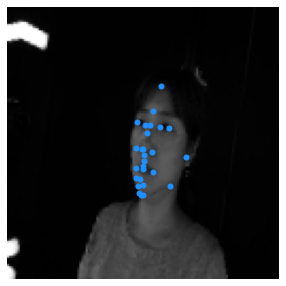

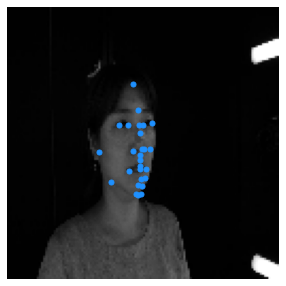

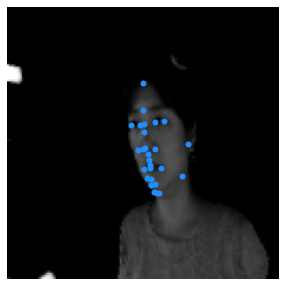

In [7]:
from src.utils.visualize import visualize_image, visualize_batch

image1, landmarks1 = train_dataset[64]
print(image1.shape)
visualize_image(image1, landmarks1)

image2, landmarks2 = train_dataset[64]
visualize_image(image2, landmarks2)

image3, landmarks3 = train_dataset[64]
visualize_image(image3, landmarks3)

In [8]:
for x, y in train_loader:
    break

print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

for x, y in valid_loader:
    break

print(x.shape, y.shape, x.max(), x.min(), y.max(), y.min())

torch.Size([64, 1, 128, 128]) torch.Size([64, 54]) tensor(1.9961) tensor(-0.0039) tensor(0.3558) tensor(-0.3081)
torch.Size([128, 1, 128, 128]) torch.Size([128, 54]) tensor(1.9961) tensor(-0.0039) tensor(0.3681) tensor(-0.3038)


Training Batch Samples


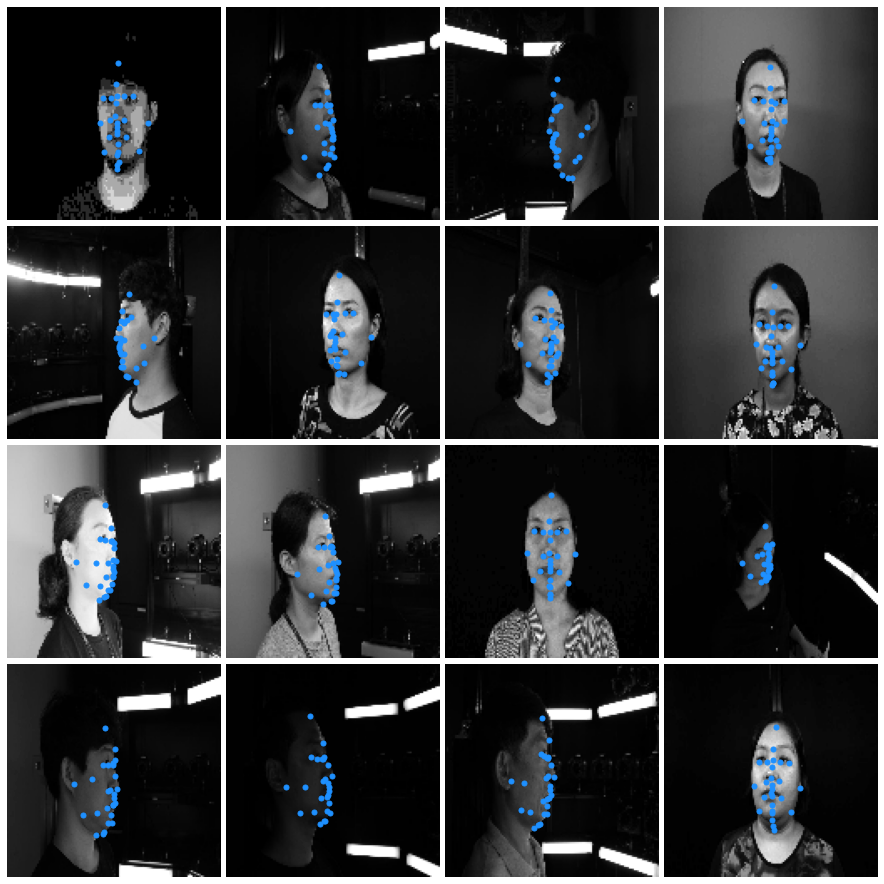

In [9]:
visualize_batch(x[:16], y[:16], shape = (4, 4), size = 16, title = 'Training Batch Samples')

**loss and optimizer**

In [10]:
import torch.optim as optim
objective = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.00002)

**define validation function**

Validating:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/9 [00:01<?, ?it/s]


Validation sample predictions


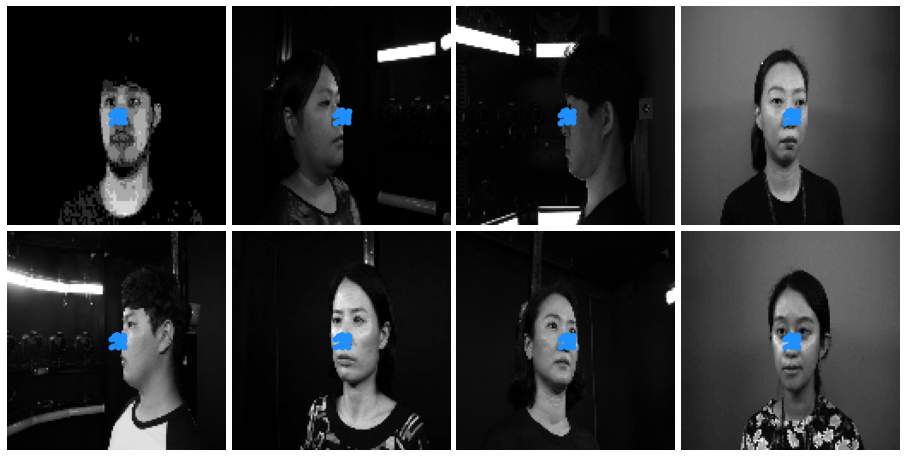

0.0011506830859515402

In [11]:
from tqdm import tqdm
model.eval()
@torch.no_grad()
def validate(save = None):
    cum_loss = 0.0

    for features, labels in tqdm(valid_loader, desc = 'Validating', ncols = 600):
        features = features.to(device)
        labels = labels.to(device)
        
        outputs = model(features)
        
        loss = objective(outputs, labels)
        cum_loss += loss.item()

        break
        
    visualize_batch(features[:8].cpu(), outputs[:8].cpu(),
                    shape = (2, 4), size = 16, title = 'Validation sample predictions', save = save)

    return cum_loss/len(valid_loader)

validate()

<All keys matched successfully>


Validating:   0%|                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 | 0/9 [00:01<?, ?it/s]


Validation sample predictions


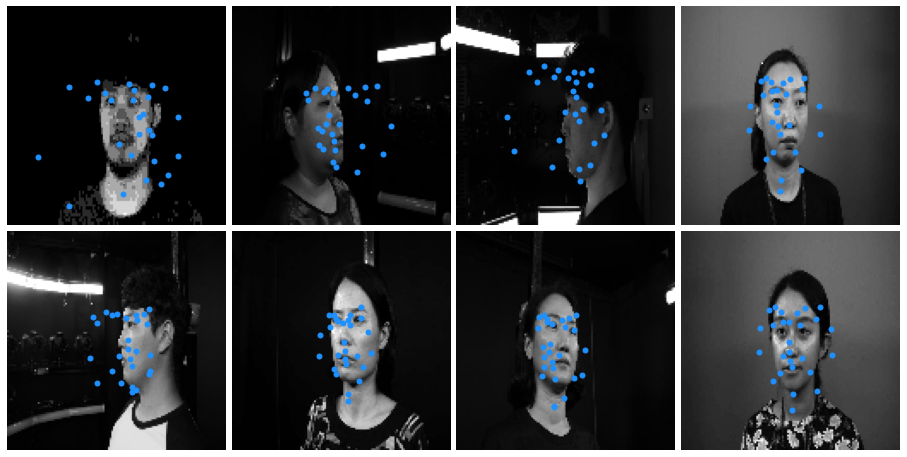

0.001509971088833279

In [14]:
from pathlib import Path
pretrained_model = '/home/ubuntu/workspace/FLD-scratch/src/models/pretrained_model/0627/xcep_27pt_50epoch_drop05.pt'
model_name = Path(pretrained_model).stem
model = xception.XceptionNet(num_classes=54)
model.eval()

if pretrained_model:
    state_dict = torch.load(pretrained_model,map_location='cpu')
    model.load_state_dict(state_dict)

model = model.to(device)

print(model.load_state_dict(state_dict))

validate()

In [16]:
if os.path.isdir('kface_progress'):
    !rm -rf progress
os.mkdir('kface_progress')

In [17]:
epochs = 100
batches = len(train_loader)
best_loss = np.inf
optimizer.zero_grad()

for epoch in range(epochs):
    cum_loss = 0.0

    model.train()
    for idx, (features, labels) in enumerate(tqdm(train_loader)):
        features = features.to(device)
        labels = labels.to(device)

        outputs = model(features)
        
        loss = objective(outputs, labels)

        loss.backward()

        optimizer.step()
        
        optimizer.zero_grad()

        cum_loss += loss.item()
        
    val_loss = validate(os.path.join('/home/ubuntu/workspace/FLD-scratch/kface_progress',
                                     f'epoch({str(epoch + 1).zfill(len(str(epochs)))}).jpg'))

    if val_loss < best_loss:
        best_loss = val_loss
        print('Saving model....................')
        save_model = '/home/ubuntu/workspace/FLD-scratch/src/models/pretrained_model/0629/xcep_27pt_50epoch_drop05.pth'
        torch.save(model.state_dict(), save_model)

    print(f'Epoch({epoch + 1}/{epochs}) -> Training Loss: {cum_loss/batches:.8f} | Validation Loss: {val_loss:.8f}')

 60%|██████    | 41/68 [00:27<00:17,  1.53it/s]